In [1]:
import pandas as pd
import json
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [2]:
# load festivals data
festivals_raw = json.load(open('all_festival_bands_2017.json'))

In [3]:
# extract genres (and other info) of bands in festivals
bands_list = []
for f in festivals_raw:
    for b in f['bands']:
        #print('{} - {} - {} - {} - {}'.format(f['name'], b['name'], b['popularity'], b['followers']['total'], b['genres']))
        bands_list.append({'festival': f['name'], 
                      'band' : b['name'], 
                      'popularity': b['popularity'], 
                      'followers' : b['followers']['total'], 
                      'genres' : b['genres']})

# convert to pandas DF
bands = pd.DataFrame.from_dict(bands_list)
bands.head()

,band,festival,followers,genres,popularity
0,SFDK,al_rumbo,151813,"[deep latin hip hop, latin hip hop, spanish hi...",54
1,Mala Rodríguez,al_rumbo,100795,"[deep latin hip hop, flamenco, latin alternati...",51
2,Estricnina,al_rumbo,6809,[spanish rock],38
3,La Raíz,al_rumbo,73371,"[spanish punk, spanish rock]",54
4,La Pegatina,al_rumbo,105792,"[spanish pop, spanish punk, spanish rock]",51


## Explore genres

In [4]:
# Number of different genres
all_unqiue_genres = set(bands['genres'].sum())
print('Total number of different genres: {}'.format(len(all_unqiue_genres)))

Total number of different genres: 479


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa27f9b3da0>]],
      dtype=object)

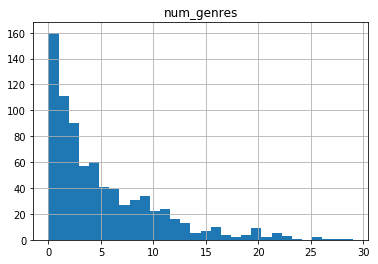

In [5]:
# Distribution of number of genres per band
bands['num_genres'] = bands['genres'].apply(lambda x: len(x))
bands.hist(column='num_genres', bins=30)
#for ng in range(0,11):
#    print('Bands with {} genres: {}'.format(ng, len(festivals_list[festivals_list['num_genres'] == ng])))

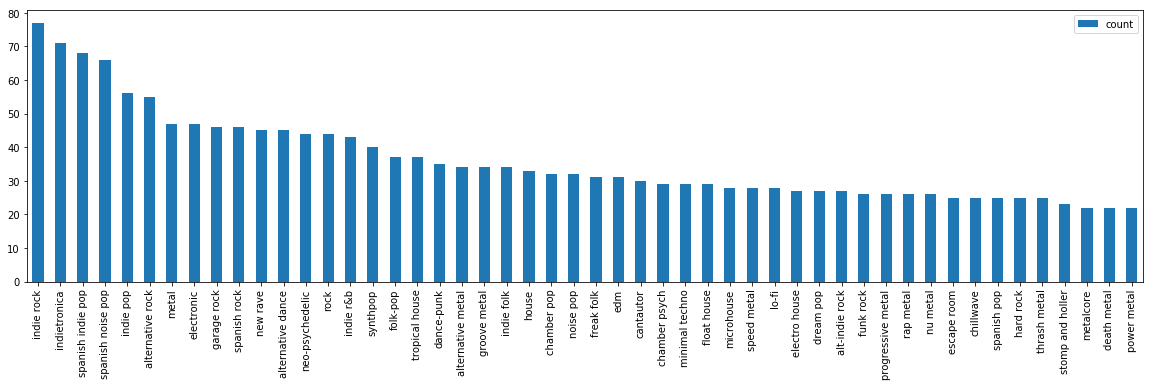

In [6]:
# Most common genres
all_genres = bands['genres'].sum()

from collections import Counter
genres_counts = Counter(all_genres)
gc_df = (pd.DataFrame.from_dict(genres_counts, orient='index'))
gc_df.columns=['count']
gc_df.sort_values(by='count',ascending=False).head(50).plot(kind='bar', figsize=(20,5))

## Vectorize list of genres to binary dimensions

In [7]:
# https://stackoverflow.com/questions/32387266/converting-categorical-values-to-binary-using-pandas
# https://stackoverflow.com/questions/40213177/pandas-convert-multiple-categories-to-dummies

In [149]:
# choose festivals to analyze
festivals_names = ['bbk','al_rumbo','cruilla','sonar']
festivals_colors = ['r','g','b','k']
#set(bands['festival'])

In [150]:
# filter bands for the given festivals
festivals_bands = bands[bands['festival'].isin(festivals_names)]
festivals_bands = festivals_bands.reset_index(drop=True)
print('{} bands in {} festivals'.format(len(festivals_bands), len(set(festivals_bands['festival']))))
festivals_bands.head()

150 bands in 4 festivals


,band,festival,followers,genres,popularity,num_genres
0,SFDK,al_rumbo,151813,"[deep latin hip hop, latin hip hop, spanish hi...",54,3
1,Mala Rodríguez,al_rumbo,100795,"[deep latin hip hop, flamenco, latin alternati...",51,5
2,Estricnina,al_rumbo,6809,[spanish rock],38,1
3,La Raíz,al_rumbo,73371,"[spanish punk, spanish rock]",54,2
4,La Pegatina,al_rumbo,105792,"[spanish pop, spanish punk, spanish rock]",51,3


In [151]:
# keep a list of unique genres for later use
festivals_genres = list(set(festivals_bands['genres'].sum()))

In [152]:
# get binary vectorization of genres
dummies = pd.get_dummies(pd.DataFrame(festivals_bands['genres'].values.tolist()), prefix_sep='', prefix='')

In [153]:
# merge dummies to main festival bands dataframe
festivals_bands = pd.concat([festivals_bands, dummies], axis=1)

In [154]:
# Check the number of genres in column 'num_genres' is equal to the sum of binary genres from dummies
if sum(festivals_bands['num_genres'] - dummies.sum(axis=1)) == 0:
    print('Correct Vectorization of genres')
else:
    print('Wrong Vectorization of genres')

Correct Vectorization of genres


## Explore PCA to reduce dimensionality

https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

In [155]:
# prepare the features x

from sklearn.preprocessing import StandardScaler

# separate
x = festivals_bands.loc[:, festivals_genres].values

# scale
#x = StandardScaler().fit_transform(x)

In [156]:
# Apply PCA

from sklearn.decomposition import PCA
pca = PCA(n_components=2)

# get principal components 
principal_components = pca.fit_transform(x)

# convert to dataframe
pca_df = pd.DataFrame(principal_components, columns = ['pc1', 'pc2'])

# merge principal components into main festival bands dataframe
festivals_bands = pd.concat([festivals_bands, pca_df], axis=1)

# print explained variance by each ratio
print('Explained variance: ', pca.explained_variance_ratio_)

Explained variance:  [0.05110257 0.03394762]


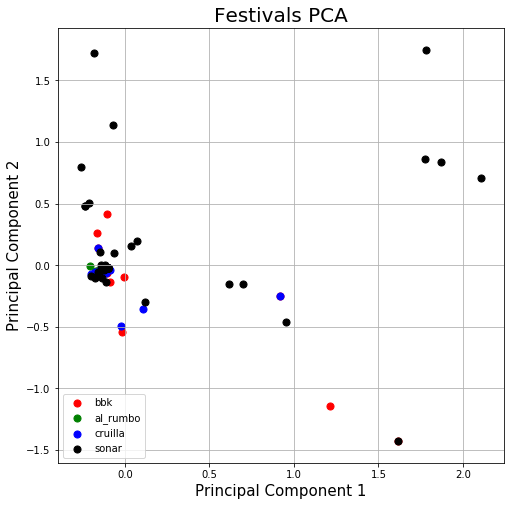

In [157]:
# scatter plot of the festivals

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Festivals PCA', fontsize = 20)

for festival, color in zip(festivals_names,festivals_colors):
    indicesToKeep = festivals_bands['festival'] == festival
    ax.scatter(festivals_bands.loc[indicesToKeep, 'pc1']
               , festivals_bands.loc[indicesToKeep, 'pc2']
               , c = color
               , s = 50)
ax.legend(festivals_names)
ax.grid()

## Explore K-means to cluster bands